In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import skew, kurtosis

from scipy.signal import find_peaks, butter, lfilter
from scipy import signal
import scipy.signal
from scipy.signal.windows import tukey
import h5py

In [2]:
# Funções para calcular os índices de qualidade
def compute_iSQI(detected_peaks, total_beats):
    return len(detected_peaks) / total_beats * 100

'''def compute_bSQI(detected_peaks_wqrs, detected_peaks_eplimited):
    common_peaks = set(detected_peaks_wqrs).intersection(detected_peaks_eplimited)
    return len(common_peaks) / len(detected_peaks_wqrs) * 100'''

def compute_fSQI(ecg_signal, sampling_rate=1000):
    fn = 0.5 * sampling_rate  # Frequência de Nyquist
    power_5_20Hz = np.sum(np.square(ecg_signal[(5 <= fn) & (fn <= 20)]))
    power_0_fnHz = np.sum(np.square(ecg_signal[fn <= 0.5 * sampling_rate]))
    return power_5_20Hz / power_0_fnHz

def compute_sSQI(ecg_signal):
    return skew(ecg_signal)

def compute_kSQI(ecg_signal):
    return kurtosis(ecg_signal)

def compute_pSQI(ecg_signal, epsilon=1.0):
    dxm_dt = np.gradient(ecg_signal)
    flat_line_percentage = np.sum(np.abs(dxm_dt) < epsilon) / len(ecg_signal) * 100
    return flat_line_percentage




# Filtragem
def preprocess(x, fs=128):
    HIGHPASS_FILTER = butter(2, 1, 'high', fs=fs)
    LOWPASS_FILTER = butter(2, 40, 'low', fs=fs)
    FILTER_COEFFS = [
        np.convolve(HIGHPASS_FILTER[0], LOWPASS_FILTER[0]),
        np.convolve(HIGHPASS_FILTER[1], LOWPASS_FILTER[1])
    ]

    x = x * WINDOW
    x1 = lfilter(*FILTER_COEFFS, x, axis=1)
    x1 = (x1 - x1.mean())/x1.std()
    return np.concatenate([x1], axis=2).astype('float32')

WINDOW = np.expand_dims(tukey(1280, 0.05), axis=(0, 2))

# Plot
def plot_detected_peaks(t, ecg_signal, detected_peaks):
    # Plotar os sinais original e filtrado com os picos QRS detectados
    plt.figure(figsize=(12, 8))
    plt.plot(t, ecg_signal, label='Sinal original', alpha=0.7)
    plt.scatter(t[detected_peaks], ecg_signal[detected_peaks], color='red', marker='o', label='Picos QRS')
    plt.title('Sinal de ECG com Picos R Detectados')
    plt.vlines(t[detected_peaks], *plt.ylim(), label="Picos", color=".2", alpha=0.3, ls="--")
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

In [3]:
import numpy as np
from scipy.fft import fft
from scipy.signal import filtfilt, butter, bessel
from scipy.signal.windows import tukey
from scipy.stats import kurtosis, skew


def zero_crossings_rate_sqi(y, threshold=1e-10, zero_pos=False, axis=-1):
    """Reuse the function from librosa package.
    This is the rate of sign-changes in the processed signal, that is,
    the rate at which the signal changes from positive to negative or back.

    Parameters
    ----------
    y :
        list, array of signal
    threshold :
        float > 0, default=1e-10 if specified, values where
        -threshold <= y <= threshold are clipped to 0.
    zero_pos :
        the crossing marker. (Default value = True)
    axis :
        axis along which to compute zero-crossings. (Default value = -1)

    Returns
    -------
    type
        float, indicator array of zero-crossings in `y` along the
        selected axis.

    """
    if threshold is not None:
        y[np.abs(y) <= threshold] = 0

    # Extract the sign bit
    if zero_pos:
        y_sign = np.signbit(y).astype(int)
    else:
        y_sign = np.sign(y)

    crossings = np.diff(y_sign, axis=axis) != 0

    return np.mean(crossings, axis=axis, keepdims=False)


def mean_crossing_rate_sqi(y, threshold=1e-10, zero_pos=True, axis=-1):
    """Expose
    Same as zero crossing rate but this function interests in the rate of
    crossing signal mean

    Parameters
    ----------
    y :
        param threshold:
    zero_pos :
        param axis: (Default value = True)
    threshold :
         (Default value = 1e-10)
    axis :
         (Default value = -1)

    Returns
    -------

    """
    return zero_crossings_rate_sqi(y-np.mean(y), threshold, zero_pos, axis)


def find_max_lenght_repeated_true(x):
    repeated = np.concatenate(([0], x, [0]))
    rep_diff = np.diff(repeated)
    rep_in = np.nonzero(rep_diff == 1)[0]
    rep_out = np.nonzero(rep_diff == -1)[0]
    if rep_in.size == 0:
        return 1
    if len(rep_out) > len(rep_in):
        rep_out = rep_out[:-2]
    return np.max(rep_out - rep_in) + 1


def flat_line_sqi(x, fs, axis=-2):
    def find_lenght_repeated(x_):
        return find_max_lenght_repeated_true(np.diff(x_) == 0) - 1
    return np.apply_along_axis(find_lenght_repeated, axis, x) / fs


def saturation_sqi(x, fs, axis=-2, threshold=2.0):
    def find_lenght_saturation(x_):
        return find_max_lenght_repeated_true(np.abs(x_) > threshold) - 1
    return np.apply_along_axis(find_lenght_saturation, axis, x) / fs


# noinspection PyTupleAssignmentBalance
def baseline_sqi(x, fs, axis=-2):
    b, a = butter(6, 1, 'low', analog=False, fs=fs)
    baseline = filtfilt(b, a, x, axis=axis)
    return np.max(np.abs(baseline), axis=axis), baseline


# noinspection PyTupleAssignmentBalance
def amplitude_sqi(x, fs, baseline=None, axis=-2):
    if baseline is None:
        baseline = filtfilt(*butter(6, 1, 'low', analog=False, fs=fs),
                            x, axis=axis)
    x = x - baseline
    x = filtfilt(*butter(2, 40, 'low', analog=False, fs=fs),
                 x, axis=axis)
    return np.max(np.abs(x), axis=axis)


def rr_variability_sqi(x, fs):
    nsig = x.shape[0]
    sig_len = x.shape[1]
    window = np.expand_dims(tukey(sig_len, 0.1), axis=(0))
    x = x * window

    x = filtfilt(*butter(2, 2, 'high', fs=fs), x, axis=1)
    x = filtfilt(*butter(2, [5, 15], 'bandpass', fs=fs), x, axis=1)
    x = filtfilt(*bessel(2, [0.5, 5], 'bandpass', fs=fs), x ** 2, axis=1)
    x = x / x.std(axis=1, keepdims=True)

    # Detect local peaks
    local_peaks = np.zeros(x.shape)
    local_peaks[:, 1:-1] = (x[:, :-2] < x[:, 1:-1]) & (x[:, 2:] < x[:, 1:-1]) & (x[:, 1:-1] > 0.5)
    rr_mean = np.zeros(nsig)
    rr_std = np.zeros(nsig)
    for i in range(nsig):
        sig_peaks = np.nonzero(local_peaks[i, :])[0]
        if len(sig_peaks) <= 1:
            rr_mean[i] = 1
            rr_std[i] = 0
        else:
            rr_mean[i] = np.mean(np.diff(sig_peaks))
            rr_std[i] = np.std(np.diff(sig_peaks))
    rr_cv = rr_std/rr_mean

    return rr_mean/fs, rr_std/fs, rr_cv


def power_sqi(x, fs):
    n = x.shape[1]

    y = fft(x, axis=1)

    # Estimates the Power Spectral Density
    y = (1 / (fs * n)) * abs(y)**2

    thresh_0 = 0
    thresh_1 = int(n/(fs/2) * 1)
    thresh_5 = int(n / (fs / 2) * 5)
    thresh_15 = int(n / (fs / 2) * 15)
    thresh_40 = int(n / (fs / 2) * 40)

    psqi = np.sum(y[:, thresh_5:thresh_15 ], axis=1) / np.sum(y[:, thresh_5:thresh_40], axis=1)
    bsqi = 1-np.sum(y[:, thresh_0:thresh_1], axis=1) / np.sum(y[:, thresh_0:thresh_40], axis=1)

    return psqi, bsqi


def kurt_sqi(x):
    return kurtosis(x, axis=1)


def skew_sqi(x):
    return skew(x, axis=1)

In [4]:
diretorio = 'D:/usuarios/estela.ribeiro/laudos/'
filename = '1j400008.h5'

# Open ECG - Movesense signal
f = h5py.File(diretorio + filename, "r")
signal = f['w_signal'][2]

# Parâmetros
sampling_rate=128
duration = 10
t = np.arange(0, duration, 1/sampling_rate)
lowcut = 1.0  # Frequência de corte inferior
highcut = 40.0  # Frequência de corte superior

# Cortar sinal para apenas 10 segundos
# Trim signal to 10 s (1280 samples)
cut_signal = signal[:1280].reshape(-1,1280,1)
ecg_signal = cut_signal[0]

# Aplicar filtro passa-banda
filtered_signal = preprocess(ecg_signal)

ecg_signal = ecg_signal[:,0]
filtered_signal = filtered_signal[0,:,0]

# Encontrar picos no sinal bruto
peaks, _ = find_peaks(filtered_signal,height=0.2, distance=sampling_rate / 2)

In [5]:
# Calcular índices de qualidade
iSQI_value = compute_iSQI(peaks, len(t))
fSQI_value = compute_fSQI(filtered_signal)
sSQI_value = compute_sSQI(filtered_signal)
kSQI_value = compute_kSQI(filtered_signal)
pSQI_value = compute_pSQI(filtered_signal)


zcr_sqi_value = zero_crossings_rate_sqi(filtered_signal)
mzcr_sqi_value = mean_crossing_rate_sqi(filtered_signal)
max_len_rep_value = find_max_lenght_repeated_true(filtered_signal)
#flat_line_sqi_value = flat_line_sqi(filtered_signal, fs=sampling_rate)
#saturation_sqi_value = saturation_sqi(filtered_signal, fs=sampling_rate)
#baseline_sqi_value = baseline_sqi(filtered_signal, fs=sampling_rate)
#amplitude_sqi_value = amplitude_sqi(filtered_signal, fs=sampling_rate)
#rr_variability_sqi_value = rr_variability_sqi(filtered_signal, fs=sampling_rate)
#power_sqi_value = power_sqi(filtered_signal, fs=sampling_rate)





# Imprimir os valores dos índices de qualidade
print(f"iSQI: {iSQI_value}")
print(f"fSQI: {fSQI_value}")
print(f"sSQI: {sSQI_value}")
print(f"kSQI: {kSQI_value}")
print(f"pSQI: {pSQI_value}")

print(f"zcr_sqi_value: {zcr_sqi_value}")
print(f"mzcr_sqi_value: {mzcr_sqi_value}")
print(f"max_len_rep_value: {max_len_rep_value}")
#print(f"flat_line_sqi_value: {flat_line_sqi_value}")
#print(f"saturation_sqi_value: {saturation_sqi_value}")
#print(f"baseline_sqi_value: {baseline_sqi_value}")
#print(f"amplitude_sqi_value: {amplitude_sqi_value}")
#print(f"rr_variability_sqi_value: {rr_variability_sqi_value}")
#print(f"power_sqi_value: {power_sqi_value}")


iSQI: 1.015625
fSQI: 0.0
sSQI: 2.9420642852783203
kSQI: 13.047220230102539
pSQI: 94.765625
zcr_sqi_value: 0.0766223612197029
mzcr_sqi_value: 0.0766223612197029
max_len_rep_value: 1


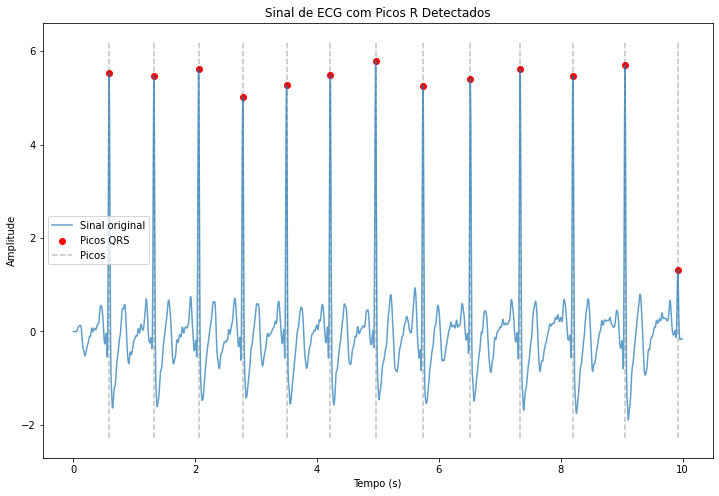

In [6]:

# Plotar os sinais original e filtrado
plot_detected_peaks(t, filtered_signal, peaks)